In [1]:
from google.colab import drive
from google.colab import data_table

drive.mount('/content/drive/')
data_table.enable_dataframe_formatter()

Mounted at /content/drive/


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from math import log

# DATA INFORMATION:



> The dataset is available publicly for the users from https://www.backblaze.com/b2/hard-drive-test-data.html#how-you-can-use-the-data


> The first row of the each file contains the column names, the remaining rows are the actual data. The columns are as follows:

##### Date – The date of the file in yyyy-mm-dd format.
##### Serial Number – The manufacturer-assigned serial number of the drive.
##### Model – The manufacturer-assigned model number of the drive.
##### Capacity – The drive capacity in bytes.
##### Failure – Contains a “0” if the drive is OK. Contains a “1” if the drive is failed.
##### S.M.A.R.T Attributes - Raw and Normalized.

> In this dataset SMART attributes have two variants namely raw value often corresponds to counts or a physical unit, such as degrees Celsius or seconds and normalized value which ranges from 1 to 253 (1 as worst case and 253 as best case).









# ML PROBLEM FORMULATION:

> It is the Binary class classification problem where we have to predict Hard Drive failure. These are predicted by using attributes that are recorded during normal operations of hard drive. These attributes are known as SMART(Self – Monitoring and Reporting Technology) which is the monitoring system included in computer HDD.

> The motive of this prediction is to reduce the rate of failures as a cost saving measure by the HDD vendors and software running on the host system may notify the user so preventive action can be taken to prevent data loss and failing drive can be replaced and data integrity is maintained.

> The HDD is said to be failed or critical when some of these attributes crosses the threshold values. Depending upon the manufacturers they use different SMART attributes in which the common attributes are like Read Error Rate, Throughput Performance, Spin-Up Time etc.

> References:
###### https://en.wikipedia.org/wiki/S.M.A.R.T
###### https://www.backblaze.com/b2/hard-drive-test-data.html#how-you-can-use-the-data









# PERFORMANCE METRICS:


1.   PRECISION, RECALL SCORES
2.   AUC SCORE AND CONFUSION MATRIX



# 1. Importing Data




In [3]:
# Using 5 days of data for Train and Val.
# dates = ['02', '03', '04', '05', '06', '07', '08', '09', '10']
dates = ['02', '03', '04', '05']
Data = pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-01.csv")
for i in dates:
  Data = Data.append(pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-" + i + ".csv"))

In [4]:
print(Data.info())
print()
print("Shape of the Data: ", Data.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827509 entries, 0 to 165532
Columns: 149 entries, date to smart_255_raw
dtypes: float64(144), int64(2), object(3)
memory usage: 947.0+ MB
None

Shape of the Data:  (827509, 149)


In [5]:
Data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,213166608.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,114.0,79306032.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000138625024,0,72.0,17162816.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,100.0,1102160.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000519643136,0,75.0,33233248.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
Data.tail()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
165528,2021-01-05,ZJV2ESXT,ST12000NM0007,12000138625024,0,80.0,97876120.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165529,2021-01-05,ZA13ZBCT,ST8000DM002,8001563222016,0,84.0,227496000.0,NaN,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165530,2021-01-05,PL1331LAHGD9NH,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,134.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165531,2021-01-05,PL2331LAHDS4TJ,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,133.0,104.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165532,2021-01-05,X0GEV9EC,WDC WUH721414ALE6L4,14000519643136,0,100.0,0.0,138.0,92.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
Data.reset_index(inplace = True)
Data['date'] = pd.to_datetime(Data['date'])
Data.columns

Index(['index', 'date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw',
       ...
       'smart_250_normalized', 'smart_250_raw', 'smart_251_normalized',
       'smart_251_raw', 'smart_252_normalized', 'smart_252_raw',
       'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized',
       'smart_255_raw'],
      dtype='object', length=150)

From the above Dataset it is found that it many features contains NaN values.

# 2. To Find the common features of all the models of HDD.







> Since each vendors provide different SMART attributes, I am finding and keeping the common attributes that each model have defined values.


> Attributes with many NaN are removed.

In [8]:
# Creating the copy of original data with removing the columns containing all instances as NaN.
Data.drop('index', axis = 1, inplace = True)
Test = Data.dropna(how = 'all', axis = 1)
Initial = Data.columns
Initial

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_250_normalized', 'smart_250_raw', 'smart_251_normalized',
       'smart_251_raw', 'smart_252_normalized', 'smart_252_raw',
       'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized',
       'smart_255_raw'],
      dtype='object', length=149)

In [9]:
Test.shape # Shape of the data after removing the NaN Features.

(827509, 139)

In [10]:
# Critical Features for HDD failure as mentioned in Wikipedia and BlackBlaze.
# These features are removed to find other common features of all the models.
Features = ['5', '10', '184', '187', '188', '196', '197', '198']
len(Features)

8

In [11]:
for i in Features:
  features = ['smart_' + i + '_normalized', 'smart_' + i + '_raw']
  Test.drop(features, axis = 1, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
# Shape of the data after removing the critical features.
Test.shape 

(827509, 123)

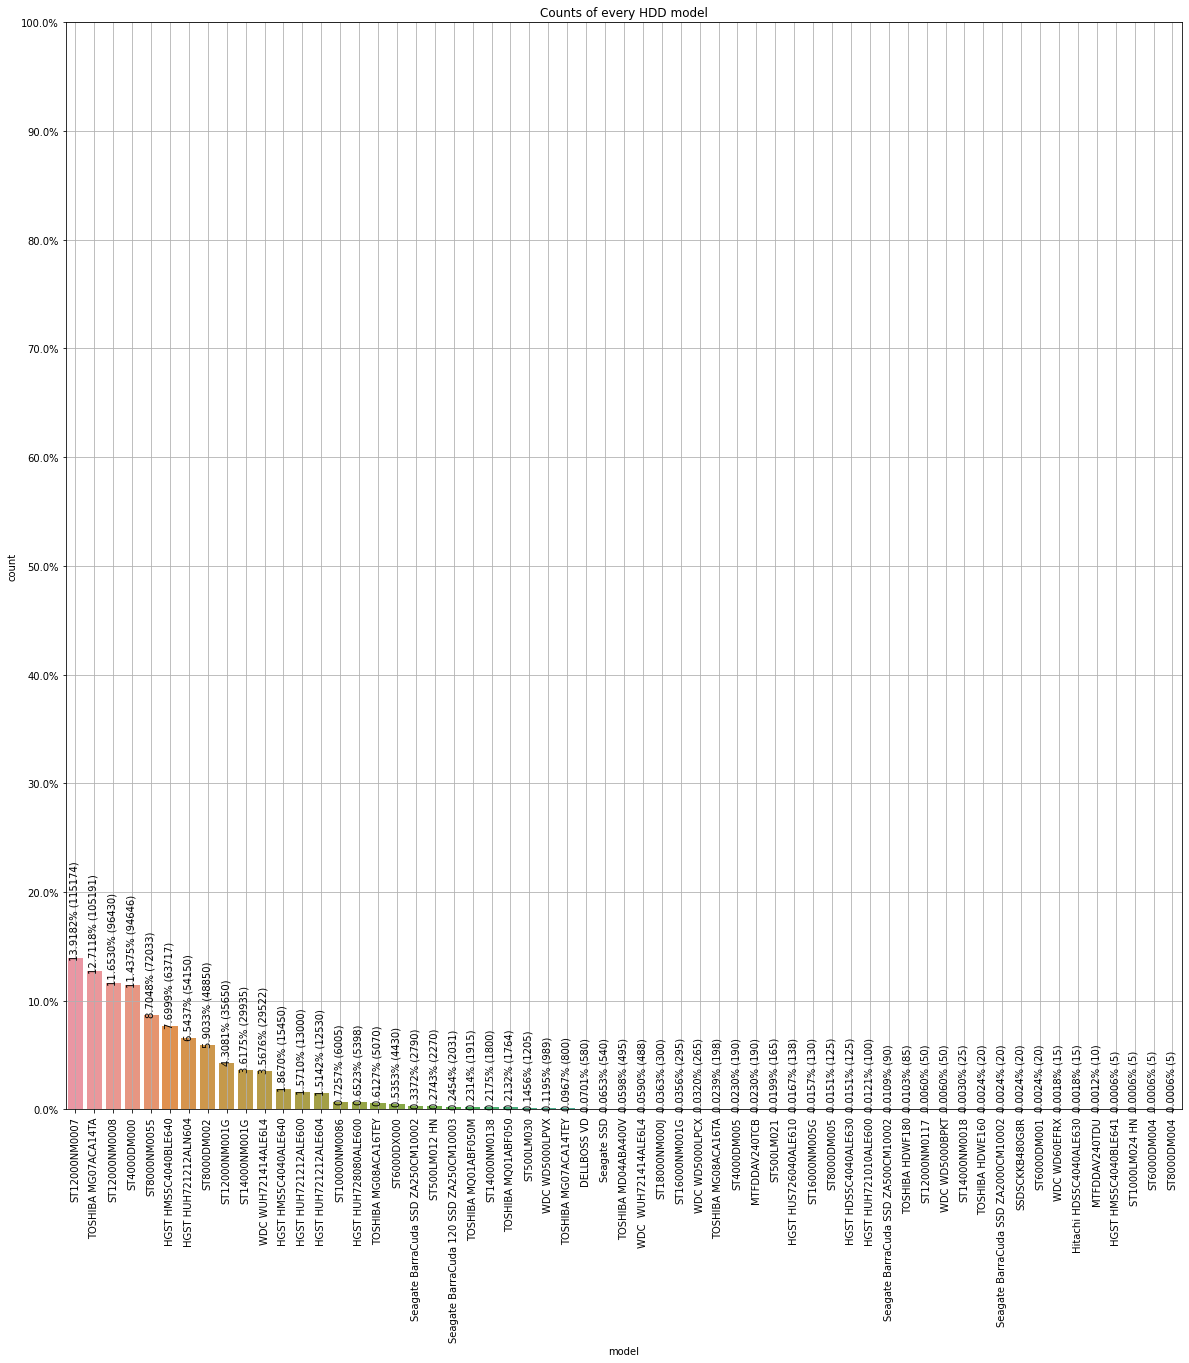

In [13]:
# Checking the count and percentage of unique models from the data.
total = len(Data)
plt.figure(figsize = (20,20))
ax = sns.countplot(x = "model", data = Test, order = Test.model.value_counts().index)
for p in ax.patches:
        ax.annotate('{:.4f}% ({})'.format(100*p.get_height()/total, p.get_height()), (p.get_x()+0.1, p.get_height()+5), rotation = 'vertical')

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.xticks(rotation=90)
plt.title('Counts of every HDD model')
plt.grid(True)
plt.show()

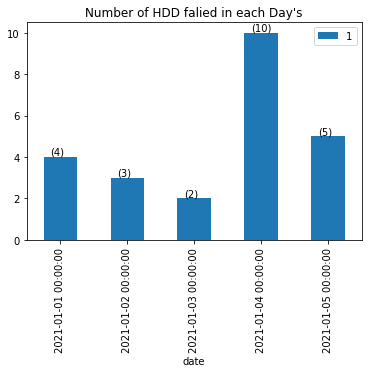

In [14]:
#This plot tells the number of HDD failed in each days
ax = Test.groupby(['date', 'failure'])['failure'].count().unstack(1)[1].plot.bar()
for p in ax.patches:
        ax.annotate('({})'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))
plt.legend()
plt.title("Number of HDD falied in each Day's")
plt.show()

In [15]:
models = Test.model.value_counts().index
print("Number of Unique Models: ", len(models))
print(models)

Number of Unique Models:  59
Index(['ST12000NM0007', 'TOSHIBA MG07ACA14TA', 'ST12000NM0008', 'ST4000DM000',
       'ST8000NM0055', 'HGST HMS5C4040BLE640', 'HGST HUH721212ALN604',
       'ST8000DM002', 'ST12000NM001G', 'ST14000NM001G', 'WDC WUH721414ALE6L4',
       'HGST HMS5C4040ALE640', 'HGST HUH721212ALE600', 'HGST HUH721212ALE604',
       'ST10000NM0086', 'HGST HUH728080ALE600', 'TOSHIBA MG08ACA16TEY',
       'ST6000DX000', 'Seagate BarraCuda SSD ZA250CM10002', 'ST500LM012 HN',
       'Seagate BarraCuda 120 SSD ZA250CM10003', 'TOSHIBA MQ01ABF050M',
       'ST14000NM0138', 'TOSHIBA MQ01ABF050', 'ST500LM030', 'WDC WD5000LPVX',
       'TOSHIBA MG07ACA14TEY', 'DELLBOSS VD', 'Seagate SSD',
       'TOSHIBA MD04ABA400V', 'WDC  WUH721414ALE6L4', 'ST18000NM000J',
       'ST16000NM001G', 'WDC WD5000LPCX', 'TOSHIBA MG08ACA16TA', 'ST4000DM005',
       'MTFDDAV240TCB', 'ST500LM021', 'HGST HUS726040ALE610', 'ST16000NM005G',
       'ST8000DM005', 'HGST HDS5C4040ALE630', 'HGST HUH721010ALE600',
   

In [16]:
# Finding the failure rate of every model in 7 days.
for i in models:
  try:
    c = Test[Test.model == i].failure.value_counts()[1] / len(Test[Test.model == i]) * 100
    print(i, 'failure_rate is {:.5f} %'.format(c))
  except KeyError:
    print(i, 'failure_rate is 0 %')

ST12000NM0007 failure_rate is 0.00347 %
TOSHIBA MG07ACA14TA failure_rate is 0.00095 %
ST12000NM0008 failure_rate is 0.00622 %
ST4000DM000 failure_rate is 0.00423 %
ST8000NM0055 failure_rate is 0 %
HGST HMS5C4040BLE640 failure_rate is 0.00157 %
HGST HUH721212ALN604 failure_rate is 0 %
ST8000DM002 failure_rate is 0 %
ST12000NM001G failure_rate is 0.00561 %
ST14000NM001G failure_rate is 0 %
WDC WUH721414ALE6L4 failure_rate is 0 %
HGST HMS5C4040ALE640 failure_rate is 0 %
HGST HUH721212ALE600 failure_rate is 0 %
HGST HUH721212ALE604 failure_rate is 0 %
ST10000NM0086 failure_rate is 0.03331 %
HGST HUH728080ALE600 failure_rate is 0 %
TOSHIBA MG08ACA16TEY failure_rate is 0 %
ST6000DX000 failure_rate is 0 %
Seagate BarraCuda SSD ZA250CM10002 failure_rate is 0 %
ST500LM012 HN failure_rate is 0 %
Seagate BarraCuda 120 SSD ZA250CM10003 failure_rate is 0.04924 %
TOSHIBA MQ01ABF050M failure_rate is 0 %
ST14000NM0138 failure_rate is 0 %
TOSHIBA MQ01ABF050 failure_rate is 0.17007 %
ST500LM030 failure_

From the above it is found that only five models have failed in these 7 days.

In [17]:
Test.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_242_normalized,smart_242_raw,smart_245_normalized,smart_245_raw,smart_247_normalized,smart_247_raw,smart_248_normalized,smart_248_raw,smart_254_normalized,smart_254_raw
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,213166608.0,NaN,NaN,99.0,...,100.0,7.022831e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,114.0,79306032.0,NaN,NaN,91.0,...,100.0,5.457889e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000138625024,0,72.0,17162816.0,NaN,NaN,98.0,...,100.0,8.706921e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,100.0,1102160.0,NaN,NaN,98.0,...,100.0,1.295292e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000519643136,0,75.0,33233248.0,NaN,NaN,95.0,...,100.0,1.872005e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Finding the features which has NaN percentage greater than 50%
M_features = Test.columns
print(Test.isnull().sum(axis = 0) / len(Test))
index = np.where(Test.isnull().sum(axis = 0) / len(Test) >= 0.5)[0]
len(index) # Count of the found features.

date                    0.000000
serial_number           0.000000
model                   0.000000
capacity_bytes          0.000000
failure                 0.000000
                          ...   
smart_247_raw           0.999988
smart_248_normalized    0.999988
smart_248_raw           0.999988
smart_254_normalized    0.998284
smart_254_raw           0.998284
Length: 123, dtype: float64


90

In [19]:
M_features[index]

Index(['smart_2_normalized', 'smart_2_raw', 'smart_8_normalized',
       'smart_8_raw', 'smart_11_normalized', 'smart_11_raw',
       'smart_13_normalized', 'smart_13_raw', 'smart_16_normalized',
       'smart_16_raw', 'smart_17_normalized', 'smart_17_raw',
       'smart_18_normalized', 'smart_18_raw', 'smart_22_normalized',
       'smart_22_raw', 'smart_23_normalized', 'smart_23_raw',
       'smart_24_normalized', 'smart_24_raw', 'smart_168_normalized',
       'smart_168_raw', 'smart_170_normalized', 'smart_170_raw',
       'smart_173_normalized', 'smart_173_raw', 'smart_174_normalized',
       'smart_174_raw', 'smart_175_normalized', 'smart_175_raw',
       'smart_177_normalized', 'smart_177_raw', 'smart_179_normalized',
       'smart_179_raw', 'smart_180_normalized', 'smart_180_raw',
       'smart_181_normalized', 'smart_181_raw', 'smart_182_normalized',
       'smart_182_raw', 'smart_183_normalized', 'smart_183_raw',
       'smart_189_normalized', 'smart_189_raw', 'smart_191_normal

##### These are the attributes which have more than 50% of NaN.

# 3. Relevant Features for Dataset

In [20]:
f = ['date',	'serial_number',	'model',	'capacity_bytes',	'failure']

In [21]:
Null = np.where(Data.isnull().sum(axis = 0) == len(Data))[0]
len(Initial[Null])

10

In [22]:
# Dropping the features with all instances as NaN from the original Dataset.
Data.dropna(how = 'all', axis = 1, inplace = True) 
print(Data.shape)
del Test # Removing the Test Dataframe to free the memory.

(827509, 139)


In [23]:
# Dropping the uncommon features found from above task from the original Dataset.
Data.drop(M_features[index], axis = 1, inplace = True)
Data.shape # Final shape of Data with relevant SMART attributes.

(827509, 49)

In [24]:
Data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,213166608.0,99.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,4910.0,100.0,4.839342e+10,100.0,7.022831e+10
1,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,114.0,79306032.0,91.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,44001.0,100.0,5.940338e+10,100.0,5.457889e+11
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000138625024,0,72.0,17162816.0,98.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,5414.0,100.0,4.917863e+10,100.0,8.706921e+10
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,100.0,1102160.0,98.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,17282.0,100.0,5.260102e+10,100.0,1.295292e+11
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000519643136,0,75.0,33233248.0,95.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,745.0,100.0,1.647225e+10,100.0,1.872005e+10


In [25]:
Data.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
count,8.275090e+05,827509.000000,826837.000000,8.268370e+05,821146.000000,821146.000000,821146.000000,821146.000000,821366.000000,821366.000000,...,821366.000000,821366.000000,821366.000000,821366.000000,617451.000000,617451.000000,531854.000000,5.318540e+05,531844.000000,5.318440e+05
mean,9.877604e+12,0.000029,92.109367,7.489772e+07,98.571473,1108.194427,99.998563,9.613792,100.555372,39.525386,...,100.420319,0.411193,196.317354,0.523777,99.958756,19539.948509,100.009401,5.612417e+10,100.009401,1.923745e+11
std,3.878876e+12,0.005385,13.814933,8.108625e+07,15.400574,2610.030659,0.105493,113.979821,8.978446,1035.302951,...,7.992256,101.417785,18.833564,37.496426,1.596372,16815.497165,0.969547,1.795249e+10,0.969556,1.765763e+11
min,-1.000000e+00,0.000000,48.000000,0.000000e+00,75.000000,0.000000,75.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,100.000000,0.000000,8.000000,0.000000,100.000000,0.000000e+00,100.000000,1.000000e+00
25%,8.001563e+12,0.000000,81.000000,0.000000e+00,91.000000,0.000000,100.000000,2.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,100.000000,2641.000000,100.000000,4.848800e+10,100.000000,1.001612e+11
50%,1.200014e+13,0.000000,100.000000,4.528490e+07,97.000000,0.000000,100.000000,5.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,100.000000,17421.000000,100.000000,5.912925e+10,100.000000,2.255465e+11
75%,1.200014e+13,0.000000,100.000000,1.441926e+08,100.000000,380.000000,100.000000,10.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,100.000000,33203.000000,100.000000,6.771780e+10,100.000000,2.620806e+11
max,1.800021e+13,1.000000,200.000000,4.515787e+08,253.000000,11111.000000,100.000000,25141.000000,252.000000,65480.000000,...,252.000000,41040.000000,200.000000,7670.000000,100.000000,67845.000000,200.000000,2.202436e+11,200.000000,2.818246e+13


In [26]:
RE = Data.columns 
RE

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_3_normalized',
       'smart_3_raw', 'smart_4_normalized', 'smart_4_raw',
       'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized',
       'smart_7_raw', 'smart_9_normalized', 'smart_9_raw',
       'smart_10_normalized', 'smart_10_raw', 'smart_12_normalized',
       'smart_12_raw', 'smart_184_normalized', 'smart_184_raw',
       'smart_187_normalized', 'smart_187_raw', 'smart_188_normalized',
       'smart_188_raw', 'smart_190_normalized', 'smart_190_raw',
       'smart_192_normalized', 'smart_192_raw', 'smart_193_normalized',
       'smart_193_raw', 'smart_194_normalized', 'smart_194_raw',
       'smart_196_normalized', 'smart_196_raw', 'smart_197_normalized',
       'smart_197_raw', 'smart_198_normalized', 'smart_198_raw',
       'smart_199_normalized', 'smart_199_raw', 'smart_240_normalized',
       'smart_240_raw', 'smart_241_normalized', 'smart_241_raw',

In [27]:
# Since the capacity is in "bytes" notation, it is difficult to interpret so it is converted into "GB" notation.
Data['capacity_bytes'] = (Data['capacity_bytes'] // 1e+9)
Data['capacity_bytes'].value_counts() # Finding the counts of each category of HDD based on GB size.

 12000.0    326984
 4000.0     174751
 14000.0    167734
 8001.0     126496
 500.0        8713
 10000.0      6076
 16000.0      5693
 250.0        5361
 6001.0       4490
 480.0         600
 18000.0       300
 240.0         200
-1.0            86
 2000.0         20
 1000.0          5
Name: capacity_bytes, dtype: int64

From the above capacity_bytes unique counts, it is found that there is unmatched size value (-1) which is seems to be odd, so datapoints with that capacity is removed.

In [28]:
# Removal of odd capacity datapoints.
print(Data.shape)
Data.drop(np.where(Data['capacity_bytes'] == -1)[0], inplace = True)
print(Data.shape)

(827509, 49)
(827423, 49)


In [29]:
# Filling the NaN values with zero since imputing with anyother values,
# may not be suitable as per the BalckBlaze documentation on SMART attributes.

Data = Data.fillna(0)
Data.isnull().sum(axis = 0)

date                    0
serial_number           0
model                   0
capacity_bytes          0
failure                 0
smart_1_normalized      0
smart_1_raw             0
smart_3_normalized      0
smart_3_raw             0
smart_4_normalized      0
smart_4_raw             0
smart_5_normalized      0
smart_5_raw             0
smart_7_normalized      0
smart_7_raw             0
smart_9_normalized      0
smart_9_raw             0
smart_10_normalized     0
smart_10_raw            0
smart_12_normalized     0
smart_12_raw            0
smart_184_normalized    0
smart_184_raw           0
smart_187_normalized    0
smart_187_raw           0
smart_188_normalized    0
smart_188_raw           0
smart_190_normalized    0
smart_190_raw           0
smart_192_normalized    0
smart_192_raw           0
smart_193_normalized    0
smart_193_raw           0
smart_194_normalized    0
smart_194_raw           0
smart_196_normalized    0
smart_196_raw           0
smart_197_normalized    0
smart_197_ra

# 4. Feature Engineering







> Feature engineering based on correlation of attributes with target variable(Failure).

> Mathematical based feature engineering.

In [30]:
Test = Data.copy()
Test.shape 

(827423, 49)

In [31]:
Test.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
count,827423.000000,827423.000000,827423.000000,8.274230e+05,827423.000000,827423.000000,827423.000000,827423.000000,827423.000000,827423.000000,...,827423.000000,827423.000000,827423.000000,827423.000000,827423.000000,827423.000000,827423.000000,8.274230e+05,827423.000000,8.274230e+05
mean,9878.203453,0.000029,92.044133,7.484468e+07,97.823690,1099.787438,99.239953,9.540860,99.819275,39.236047,...,99.685211,0.408183,194.880249,0.519943,74.592601,14581.369804,64.284411,3.607570e+10,64.283202,1.236529e+11
std,3877.916088,0.005386,14.025749,8.108202e+07,17.565005,2601.889063,8.677299,113.549724,12.389478,1031.512115,...,11.691369,101.045904,25.142999,37.358957,43.520472,16831.774762,47.928770,3.050290e+10,47.929130,1.689341e+11
min,240.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,8001.000000,0.000000,81.000000,0.000000e+00,91.000000,0.000000,100.000000,2.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,12000.000000,0.000000,100.000000,4.514909e+07,97.000000,0.000000,100.000000,5.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,100.000000,5816.000000,100.000000,4.683655e+10,100.000000,9.188942e+10
75%,12000.000000,0.000000,100.000000,1.441262e+08,100.000000,380.000000,100.000000,10.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,100.000000,29337.000000,100.000000,6.341446e+10,100.000000,2.468640e+11
max,18000.000000,1.000000,200.000000,4.515787e+08,253.000000,11111.000000,100.000000,25141.000000,252.000000,65480.000000,...,252.000000,41040.000000,200.000000,7670.000000,100.000000,67845.000000,200.000000,2.202436e+11,200.000000,2.818246e+13


##### From the above description it is seen that some attributes have values ranging from 10^7 to 10^13 which seems to be odd. Such attributes are choosen for Feature engineering. 
##### Inspite of Column Standardisation or Normalisation, Sigmoid and Tanh functions are applied on these attributes as a scaling function and it's correlation with target varibale is compared with its original correlation values.

In [32]:
# Sigmoid and TanH Functions.
# Instead of using original value, it is added with random normal distributed value just like adding bias to the input value.
def Sigmoid(x):
  return 1 / (1 + np.exp(-(x + np.random.normal(scale = 0.5)))) 
def TanH(x):
  return np.tanh(x + np.random.normal(scale = 0.5))

In [33]:
# Creating new attributes based on above description.

#Test['smart_1_sig'] = Test['smart_1_raw'].apply(Sigmoid)
#Test['smart_7_sig'] = Test['smart_7_raw'].apply(Sigmoid)
#Test['smart_188_sig'] = Test['smart_188_raw'].apply(Sigmoid)
#Test['smart_193_sig'] = Test['smart_193_raw'].apply(Sigmoid)
#Test['smart_195_sig'] = Test['smart_195_raw'].apply(Sigmoid)
#Test['smart_240_sig'] = Test['smart_240_raw'].apply(Sigmoid)
#Test['smart_241_sig'] = Test['smart_241_raw'].apply(Sigmoid)
#Test['smart_242_sig'] = Test['smart_242_raw'].apply(Sigmoid)

#Test['smart_1_tan'] = Test['smart_1_raw'].apply(TanH)
#Test['smart_7_tan'] = Test['smart_7_raw'].apply(TanH)
#Test['smart_188_tan'] = Test['smart_188_raw'].apply(TanH)
#Test['smart_193_tan'] = Test['smart_193_raw'].apply(TanH)
#Test['smart_195_tan'] = Test['smart_195_raw'].apply(TanH)
#Test['smart_240_tan'] = Test['smart_240_raw'].apply(TanH)
#Test['smart_241_tan'] = Test['smart_241_raw'].apply(TanH)
#Test['smart_242_tan'] = Test['smart_242_raw'].apply(TanH)

cf = ['smart_1_raw', 'smart_7_raw', 'smart_188_raw', 'smart_193_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw']
for i in cf:
   n = re.findall('\d+',i) 
   s = 'smart_' + ''.join(n) + '_sig'
   t = 'smart_' + ''.join(n) + '_tan'
   Test[s] = Test[i].apply(Sigmoid)
   Test[t] = Test[i].apply(TanH)

In [34]:
Test.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_188_sig,smart_188_tan,smart_193_sig,smart_193_tan,smart_240_sig,smart_240_tan,smart_241_sig,smart_241_tan,smart_242_sig,smart_242_tan
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000.0,0,83.0,213166608.0,99.0,0.0,100.0,...,0.419784,-0.019592,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2021-01-01,Z305B2QN,ST4000DM000,4000.0,0,114.0,79306032.0,91.0,0.0,100.0,...,0.432921,-0.503234,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000.0,0,72.0,17162816.0,98.0,0.0,100.0,...,0.684625,0.444060,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000.0,0,100.0,1102160.0,98.0,0.0,100.0,...,0.404626,-0.518073,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000.0,0,75.0,33233248.0,95.0,0.0,100.0,...,0.738419,0.350014,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [35]:
# Checking the correlation of attributes with target variable.
cf = ['smart_1_raw', 'smart_1_sig', 'smart_1_tan', 'smart_7_raw', 'smart_7_sig', 'smart_7_tan', 'smart_188_raw', 'smart_188_sig', 'smart_188_tan', 'smart_193_raw', 'smart_193_sig', 'smart_193_tan', 'smart_240_raw', 'smart_240_sig', 'smart_240_tan', 'smart_241_raw', 'smart_241_sig', 'smart_241_tan', 'smart_242_raw', 'smart_242_sig', 'smart_242_tan']
j = 1
for i in cf:
  print(i + ' feature' + ' Correlation with target(Failure)' + ' is ' + str(Test[i].corr(Test['failure']))) # This line computes the correlation.
  if(j % 3 == 0):
    print()
  j+=1

smart_1_raw feature Correlation with target(Failure) is 0.0004930565827411704
smart_1_sig feature Correlation with target(Failure) is 0.0019443814117698626
smart_1_tan feature Correlation with target(Failure) is 0.0012503681931835488

smart_7_raw feature Correlation with target(Failure) is -1.8360522051362562e-05
smart_7_sig feature Correlation with target(Failure) is 0.0007825140683420018
smart_7_tan feature Correlation with target(Failure) is 0.0004720320902364148

smart_188_raw feature Correlation with target(Failure) is 0.00044184288658845447
smart_188_sig feature Correlation with target(Failure) is 0.0022726067329404505
smart_188_tan feature Correlation with target(Failure) is 0.0025224264874442602

smart_193_raw feature Correlation with target(Failure) is -0.0016981571065426927
smart_193_sig feature Correlation with target(Failure) is -0.004341515176097014
smart_193_tan feature Correlation with target(Failure) is -0.00492582573938321

smart_240_raw feature Correlation with target

##### From the above correlation values, attributes obtained from Sigmoid function shows the better correlation than the TanH function. It also show good values when compared with original raw values. 
##### But, smart_188_sig and smart_241_sig correlation values are still less than it's original raw values, which seems that sigmoidal values dosen't improve the correlation result. Thus, these attributes are not used for feature engineering.

#### Response Encoding the "Model" feature.

> It is a method of creating the True and False probabilities for Categorical Data.

> True Probability = No. of (respec. cat. data with target = 1) / (Total no. of that cat. data).

> False Probability = No. of (respec. cat. data with target = 0) / (Total no. of that cat. data).









In [36]:
# Function for Claculating the probabilities of categorical data.
def res_fit(cat, Y):
    j = dict(cat.value_counts()) # Storing the counts of each category in Dictionary. 
    true, false = 0, 0
    TRUE, FALSE = {}, {} 
    for key, value in j.items(): # Iterating over each category
        sum, neg, = 0, 0
        for state, y in zip(cat, Y): # Iterating over every data in given Series
            if (key == state and y == 1): 
                sum+= 1              # Calculating count when target of respective category data is 1
            elif (key == state and y == 0):
                neg+= 1              # Calculating count when target of respective category data is 0
        true = sum / value           # Dividing the True count with the respective total category count.
        false = neg / value          # Dividing the False count with the respective total category count.
        TRUE[key] = true
        FALSE[key] = false           # The respective category data with it's True probability and False probability is stored in dictionary.
    return j, TRUE, FALSE

In [37]:
# Function for transforming the query data points into respective calculated probability values.
def res_transform(cat, TRUE, FALSE):
    t = []
    f = []
    for state in cat: # Iterating over each data point in a given query series.
        for ((key_t, value_t), (key_f, value_f)) in zip(TRUE.items(), FALSE.items()): # Iterating over the calculated True and False probabilities 

            # When the respective category data from query series is matched, it is then appended with it's respective probability values. 
            if state == key_t and state == key_f: 
                t.append(value_t)                 
                f.append(value_f)
                break
        else :           # Incase, when the unknown category data is found, it's True and False probability values are considered as 0.5 and 0.5.
                t.append(1/2)
                f.append(1/2) 

    X_t = np.array(t).reshape(-1, 1)
    X_f = np.array(f).reshape(-1, 1) # Reshaping the above array
    
    return np.concatenate((X_t, X_f), axis = 1) 

In [38]:
del Test

# 5. Final Dataset





> From the above task, attributes with respective transformation which given better correlation values than it's original raw values are used as a attributes for feature transformation in final dataset.

In [39]:
print("Original shape of Data : ", Data.shape)
cf = ['smart_1_raw', 'smart_7_raw', 'smart_193_raw', 'smart_240_raw', 'smart_242_raw']
for i in cf:
   n = re.findall('\d+',i) 
   s = 'smart_' + ''.join(n) + '_sig'
   Data[s] = Data[i].apply(Sigmoid)

print("Final shape of Data : ", Data.shape)

Original shape of Data :  (827423, 49)
Final shape of Data :  (827423, 54)


In [40]:
Data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_1_sig,smart_7_sig,smart_193_sig,smart_240_sig,smart_242_sig
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000.0,0,83.0,213166608.0,99.0,0.0,100.0,...,4910.0,100.0,4.839342e+10,100.0,7.022831e+10,1.0,1.0,1.0,1.0,1.0
1,2021-01-01,Z305B2QN,ST4000DM000,4000.0,0,114.0,79306032.0,91.0,0.0,100.0,...,44001.0,100.0,5.940338e+10,100.0,5.457889e+11,1.0,1.0,1.0,1.0,1.0
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000.0,0,72.0,17162816.0,98.0,0.0,100.0,...,5414.0,100.0,4.917863e+10,100.0,8.706921e+10,1.0,1.0,1.0,1.0,1.0
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000.0,0,100.0,1102160.0,98.0,0.0,100.0,...,17282.0,100.0,5.260102e+10,100.0,1.295292e+11,1.0,1.0,1.0,1.0,1.0
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000.0,0,75.0,33233248.0,95.0,0.0,100.0,...,745.0,100.0,1.647225e+10,100.0,1.872005e+10,1.0,1.0,1.0,1.0,1.0


In [41]:
# Splitting the Dataset into Train and Val Dataset based on date
split_date = '2021-01-03'

In [42]:
Train = Data.loc[Data.date <= split_date]
Val = Data.loc[Data.date > split_date]
print(Train.shape, Val.shape)

(496415, 54) (331008, 54)


In [43]:
# Response encoding the 'model' feature.
values, TR, FA = res_fit(Train['model'], Train['failure'].values)
print(values)
print()
Train_model = res_transform(Train['model'], TR, FA)
Val_model = res_transform(Val['model'], TR, FA)
print('*'*50)
print(Train_model.shape)
print(Val_model.shape)

{'ST12000NM0007': 69106, 'TOSHIBA MG07ACA14TA': 63099, 'ST12000NM0008': 57859, 'ST4000DM000': 56775, 'ST8000NM0055': 43219, 'HGST HMS5C4040BLE640': 38229, 'HGST HUH721212ALN604': 32490, 'ST8000DM002': 29310, 'ST12000NM001G': 21386, 'ST14000NM001G': 17961, 'WDC WUH721414ALE6L4': 17686, 'HGST HMS5C4040ALE640': 9241, 'HGST HUH721212ALE600': 7800, 'HGST HUH721212ALE604': 7518, 'ST10000NM0086': 3603, 'HGST HUH728080ALE600': 3238, 'TOSHIBA MG08ACA16TEY': 3042, 'ST6000DX000': 2658, 'Seagate BarraCuda SSD ZA250CM10002': 1674, 'ST500LM012 HN': 1362, 'Seagate BarraCuda 120 SSD ZA250CM10003': 1218, 'TOSHIBA MQ01ABF050M': 1149, 'ST14000NM0138': 1080, 'TOSHIBA MQ01ABF050': 1059, 'ST500LM030': 723, 'WDC WD5000LPVX': 593, 'TOSHIBA MG07ACA14TEY': 480, 'DELLBOSS VD': 348, 'Seagate SSD': 324, 'TOSHIBA MD04ABA400V': 297, 'WDC  WUH721414ALE6L4': 293, 'ST18000NM000J': 180, 'ST16000NM001G': 177, 'WDC WD5000LPCX': 159, 'TOSHIBA MG08ACA16TA': 118, 'ST4000DM005': 114, 'MTFDDAV240TCB': 114, 'ST500LM021': 99, 'H

0    496406
1         9
Name: failure, dtype: int64


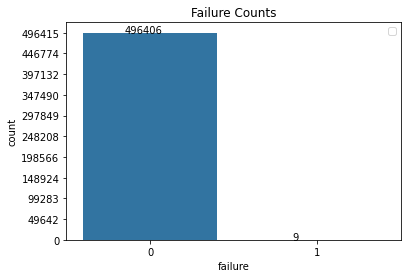

In [44]:
# Checking the balance of the Train Dataset.
total = len(Train)
print(Train.failure.value_counts())
ax = sns.countplot(x = 'failure', data = Train)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.legend()
plt.title("Failure Counts")
plt.show()

0    330993
1        15
Name: failure, dtype: int64


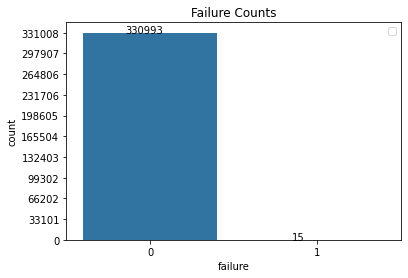

In [45]:
# Checking the balance of the Val Dataset.
total = len(Val)
print(Val.failure.value_counts())
ax = sns.countplot(x = 'failure', data = Val)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.legend()
plt.title("Failure Counts")
plt.show()

From the above, it is found that Dataset is highly imbalanced with class 1 (i.e. HDD is failure) as minority.

In [46]:
#del Data

In [47]:
#Train.drop('smart_241_normalized', axis = 1, inplace = True)
#Val.drop('smart_241_normalized', axis = 1, inplace = True)

# 6. Upsampling of Minority Class of Train using SMOTE





> Instead of upsampling the minority class by normal sampling (i.e. creating duplicates of same points) SMOTE technique is used as upsampling technique as it upsamples by interpolation.

In [48]:
X_Train_orig = Train.drop(f, axis = 1).values
Y_Train_orig = Train.failure.values
X_Val_orig = Val.drop(f, axis = 1).values
Y_Val_orig = Val.failure.values

In [49]:
X_Train_orig.shape, Y_Train_orig.shape

((496415, 49), (496415,))

In [50]:
X_Val_orig.shape, Y_Val_orig.shape

((331008, 49), (331008,))

In [51]:
# Stacking the response encoded array with respective Train and Val dataset.
X_Train_orig = np.hstack((X_Train_orig, Train_model))
X_Val_orig = np.hstack((X_Val_orig, Val_model))
X_Train_orig.shape, X_Val_orig.shape

((496415, 51), (331008, 51))

In [52]:
del Train_model
del Val_model

In [53]:
Counter(Y_Train_orig), Counter(Y_Val_orig)

(Counter({0: 496406, 1: 9}), Counter({0: 330993, 1: 15}))

In [54]:
# SMOTE sampling
# class imblearn.over_sampling.SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5, m_neighbors='deprecated', out_step='deprecated', kind='deprecated', svm_estimator='deprecated', n_jobs=1, ratio=None)
# k_neighbors (default=5) : number of nearest neighbours to used to construct synthetic samples.
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under = RandomUnderSampler(sampling_strategy = 0.8)
over_smote = SMOTE(n_jobs = -1, k_neighbors = 1, sampling_strategy = 0.5)
steps = [('o', over_smote), ('u', under)]
pipeline = Pipeline(steps = steps)

In [55]:
# SMOTE oversampling is applied on Train dataset as per oversampling concepts.
# Since Val dataset is also highly imbalanced, regular oversampling is applied(i.e creating duplicates of minority class)

x_train_sam, y_train_sam = pipeline.fit_resample(X_Train_orig, Y_Train_orig) # Resampling the Training Data by oversampling the minority class using SMOTE 
#and undersampling the majority class.
x_val, y_val = X_Val_orig, Y_Val_orig

In [56]:
x_train_sam.shape, y_train_sam.shape # Final shape of Train datapoints.

((558456, 51), (558456,))

In [57]:
x_val.shape, y_val.shape # Final shape of Val datapoints.

((331008, 51), (331008,))

Counter({0: 310253, 1: 248203})


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


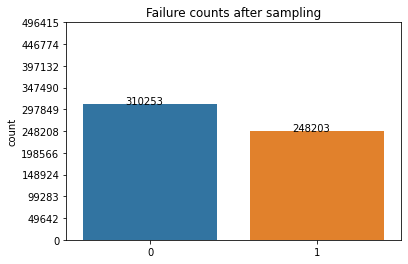

In [58]:
# Visualization after balancing Train Dataset.
total = len(X_Train_orig)
print(Counter(y_train_sam))
ax = sns.countplot(y_train_sam)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.title("Failure counts after sampling")
plt.show()

Counter({0: 330993, 1: 15})


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


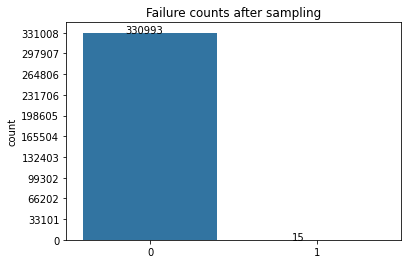

In [59]:
# Visualization after balancing Val Dataset.
total = len(X_Val_orig)
print(Counter(y_val))
ax = sns.countplot(y_val)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.title("Failure counts after sampling")
plt.show()

From the above it is seen that, after oversampling both classes are balanced.

# 7. Standardization:

In [60]:
from sklearn.preprocessing import Normalizer, StandardScaler
normalizer = Normalizer()
sc = StandardScaler()

In [61]:
# Standardizing both Train and Val Dataset.
sc.fit(x_train_sam)

X_train_standard = sc.transform(x_train_sam)
X_val_standard = sc.transform(x_val)

In [62]:
print("Train", np.mean(X_train_standard), np.std(X_train_standard))
print("Val", np.mean(X_val_standard), np.std(X_val_standard))
print(X_train_standard.shape, X_val_standard.shape)

Train 8.275863925909262e-11 1.0000000000000784
Val 0.0312958254530624 1.0183778266099173
(558456, 51) (331008, 51)


In [63]:
X_val_standard[0]

array([-0.69739805,  1.32333627,  0.33764925, -0.48521896,  0.29000489,
       -0.09771623,  0.29166953, -0.33664309,  0.14623736, -0.00255364,
        0.81599901, -0.95315738,  0.26493365, -0.01533189,  0.01972142,
       -0.68755316, -0.65604398, -0.00219087,  1.05930564, -0.13851455,
        0.75537945, -0.03623869,  0.74250635,  0.73381732, -0.01633046,
       -0.22853511,  0.43016381, -0.34813985, -0.62684587, -0.01657539,
       -0.68941297, -0.00820535,  0.26711695, -0.21597993,  0.26587706,
       -0.21520329,  0.32646084, -0.0105133 ,  0.56759149, -0.6228905 ,
        0.67751372,  0.34357234,  0.67752493, -0.38416363,  0.68223801,
        0.73510858,  0.31523833,  0.73235085,  0.66456491, -0.45218267,
        0.45218267])

# 8. Test Dataset

In [64]:
# Creating the Test Dataset to check performance of the model.
# Test data is from 2021-01-06 to 2019-01-07

Dates = ['07']
Test = pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-06.csv")
for i in Dates:
  Test = Test.append(pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-" + i + ".csv"))

# Test = pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-06.csv")
# Test = Test.append(pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-07"))

Test.reset_index(inplace = True)
Test.drop('index', axis = 1, inplace = True)
Test.shape

(330211, 149)

In [65]:
Test.failure.value_counts()

0    330204
1         7
Name: failure, dtype: int64

In [66]:
# Preprocessing of Test Data.
Test.drop(Initial[Null], axis = 1, inplace = True)
Test.drop(M_features[index], axis = 1, inplace = True)
Test.shape

(330211, 49)

In [67]:
print(Test.shape)
Test.drop(np.where(Test['capacity_bytes'] == -1)[0], inplace = True)
print(Test.shape)

(330211, 49)
(330155, 49)


In [68]:
Test.failure.value_counts()

0    330148
1         7
Name: failure, dtype: int64

In [69]:
Test = Test.fillna(0)

In [70]:
for i in cf:
   n = re.findall('\d+',i) 
   s = 'smart_' + ''.join(n) + '_sig'
   Test[s] = Test[i].apply(Sigmoid)
Test.shape

(330155, 54)

In [71]:
Test_model = res_transform(Test['model'], TR, FA)

In [72]:
X_Test_orig = Test.drop(f, axis = 1).values
Y_Test_orig = Test.failure.values

In [73]:
X_Test_orig = np.hstack((X_Test_orig, Test_model))
X_Test_orig.shape

(330155, 51)

In [74]:
x_test, y_test = X_Test_orig, Y_Test_orig

In [75]:
x_test.shape

(330155, 51)

In [76]:
(Counter(y_test))

Counter({0: 330148, 1: 7})

In [77]:
# Standardisation of Test Dataset.
X_test_standard = sc.transform(x_test)
X_test_standard.shape

(330155, 51)

# 9. Modelling

In [78]:
import warnings
warnings.filterwarnings("ignore")
from random import sample, choice
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, classification_report, f1_score, precision_recall_curve
from scipy.stats import randint as sp_randint, uniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC

balance = [{0:1,1:10}, {0:1,1:100}, {0:1,1:1000}, {0:1,1:10000}, {0:10,1:100000}]

In [79]:
# This function is used to plot Cofusion Matrix, Precision Matrix and Recall Matrix.
def plot_matrices(Y, Y_Pred):
    C = confusion_matrix(Y, Y_Pred) # Confusion Matrix
    
    A =(((C.T)/(C.sum(axis=1))).T) # Calculating Recall Matrix
    
    B =(C/C.sum(axis=0)) # Calculating Precision Matrix
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    print("Sum of rows in recall matrix",A.sum(axis=1))
    
    plt.show()


In [80]:
# This function prints the metrics of the model.
def Metrics(model, X, Y, threshold):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)

    print("The Prescision Score: ", precision_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print("The Recall Score: ", recall_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print("The ROC Score: ", roc_auc_score(Y, y_pred_prob))
    print("The F1 Score: ", f1_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print('*'*100)
    print(classification_report(Y, predict_with_best_t(y_pred_prob, threshold)))
    print('*'*100)
    plot_matrices(Y, predict_with_best_t(y_pred_prob, threshold))

In [81]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [82]:
def find_best_threshold(threshould, fpr, tpr):
    # This function finds the optimal threshold value based on G-Mean metric
    # The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.
    # Ref: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    t = threshould[np.argmax(np.sqrt(tpr*(1-fpr)))]
    # sqrt(tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of sqrt(tpr*(1-fpr))", max(np.sqrt(tpr*(1-fpr))), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould): # This function predicts class labels based on the optimal threshold value.
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def BEST(trainscores, testscores, TR, Models): # This function is used to get the best model based on the highest test score.
  ind = np.argmax(testscores)
  test_score = testscores[ind]
  train_score = trainscores[ind]
  threshold = TR[ind]
  best_est = Models[ind]
  return test_score, train_score, threshold, best_est

# 9.1.  LOGISTIC REGRESSION

In [83]:
# Hyperparameter tuning of Logistic Regression
param = {'C' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],
         'penalty' : ['l1', 'l2', 'elasticnet'],
         'l1_ratio' : list(np.sort(np.random.uniform(0, 1, 10))),
         'class_weight' : balance}
LR = LogisticRegression(n_jobs = -1, solver = 'saga')
param

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0, 100000.0],
 'penalty': ['l1', 'l2', 'elasticnet'],
 'l1_ratio': [0.0351648153084031,
  0.0751144315451161,
  0.08414122397436541,
  0.1061435603745452,
  0.6155347216921886,
  0.7082318656364713,
  0.8044277457885703,
  0.8290321045048892,
  0.9133515870728559,
  0.9437813902681133],
 'class_weight': [{0: 1, 1: 10},
  {0: 1, 1: 100},
  {0: 1, 1: 1000},
  {0: 1, 1: 10000},
  {0: 10, 1: 100000}]}

This custom Random SearchCV is built on the original Training dataset with stratifiedkfold split where at each fold the generated training data is sampled and trained with assigned parameter and evaluated on the generated unsampled val data using f1-score metric.

In [84]:
# Creating custom RandomSearchCV for hyperparameter tuning.
# In this Cross-Validation is done by StratifiedKFold

trainscores = [] # This list is to store the trainscores
testscores  = [] # This list is to store the testscores
Models = [] # This list is to store the models on each iter
TR = []
# This loop is to use ten random values for each hyperparameter
for iter in tqdm(range(0, 10)):
  #print(iter)
  Thresholds = []
  trainscores_folds = []
  testscores_folds  = []
  w = 0
  LR = LogisticRegression(n_jobs = -1, solver = 'saga')
  for key, value in param.items(): # Assigns the value for each hyperparameter
    if isinstance(value, list):
      if (key == 'C'):
        LR.C = value[iter]
      if (key == 'penalty'):
        LR.penalty = choice(value)
      if (key == 'l1_ratio'):
        LR.l1_ratio = value[iter]
      #if (key == 'class_weight'):
       # LR.class_weight = choice(value)
  #print(LR)
  Models.append(LR)
  #print(Models)
  ss = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1) # Splitting the training data into train and val data 
  # using stratifiedKFold (10-folds) to ensure that each fold consists of both classes.
  # Running the loop for each fold
  for train, test in ss.split(X_Train_orig, Y_Train_orig): # This loop uses original training dataset.
      print()
      X_train = np.zeros(len(train))
      Y_train = np.zeros(len(train))
      X_test = np.zeros(len(test))
      Y_test = np.zeros(len(test))

      # selecting the data points based on the train_indices and test_indices
      X_train = X_Train_orig[train]
      Y_train = Y_Train_orig[train]
      X_test  = X_Train_orig[test]
      Y_test  = Y_Train_orig[test]
      print("B", Counter(Y_train)) # Count of training classes before sampling

      X_train, Y_train = pipeline.fit_resample(X_train, Y_train) # Sampling the training data by the above defined pipeline
      print("A", Counter(Y_train)) # Count of training classes after sampling
      # Standardizing the above train and val data.
      sc = StandardScaler()
      sc.fit(X_train)
      X_train = sc.transform(X_train)
      X_test = sc.transform(X_test)

      LR.fit(X_train,Y_train)

      Y_predicted_test = LR.predict_proba(X_test)[:, 1]

      Y_predicted_train = LR.predict_proba(X_train)[:, 1]

      # This following snippets are used tuning the thresholds generated by roc_curve 
      train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, Y_predicted_train)
      test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, Y_predicted_test)
      #thresholds = np.linspace(0.0, 1.0, num=len(te_thresholds))
      best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr) # Finding the best threshold based on the prediction on val data
      Thresholds.append(best_t)

      # F1-score based on the optimal threshold value
      print('Train', f1_score(Y_train, predict_with_best_t(Y_predicted_train, best_t)))
      trainscores_folds.append(f1_score(Y_train, predict_with_best_t(Y_predicted_train, best_t)))

      print('Test', f1_score(Y_test, predict_with_best_t(Y_predicted_test, best_t)))
      testscores_folds.append(f1_score(Y_test, predict_with_best_t(Y_predicted_test, best_t)))

  # print(trainscores_folds)
  TR.append(Thresholds[np.argmax(testscores_folds)]) 
  trainscores.append(np.mean(np.array(trainscores_folds))) # Taking the mean of trainscores obtained from each fold
  testscores.append(np.mean(np.array(testscores_folds))) # Taking the mean of testscores obtained from each fold
  print() 

  0%|          | 0/10 [00:00<?, ?it/s]


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.49291427753952977 for threshold 0.037
Train 0.6782716949049614
Test 5.321696556862327e-05

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.956203353079523 for threshold 0.352
Train 0.9190318397925372
Test 0.00047003525264394824

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9978825712046798 for threshold 0.841
Train 0.5843778858488218
Test 0.009433962264150945

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.8276949113409753 for threshold 0.228
Train 0.833391146519865
Test 0.00012791813239526704

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9997683098170282 for threshold 0.999
Train 0.06954125746072055
Test 0.07999999999999999

B Counter({0: 446765, 1: 9})
A

 10%|█         | 1/10 [13:42<2:03:22, 822.50s/it]

Test 5.3613553506326395e-05


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.680710639611014 for threshold 0.006
Train 0.7483985526668453
Test 7.507225704740814e-05

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9641130171680534 for threshold 0.273
Train 0.9579378233675899
Test 0.0005712653527563554

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9983770396001611 for threshold 0.991
Train 0.501768838379283
Test 0.012269938650306747

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9998690512759368 for threshold 1.0
Train 0.0
Test 0.13333333333333333

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9994055564825707 for threshold 0.999
Train 0.2732636892334647
Test 0.03278688524590164

B Counter({0: 446765, 1:

 20%|██        | 2/10 [27:56<1:52:09, 841.18s/it]

Test 5.4821555835754616e-05


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.6891078024994954 for threshold 0.003
Train 0.7526525221282173
Test 7.671653241273494e-05

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9623772128854395 for threshold 0.257
Train 0.9559782341222715
Test 0.000545404963185165

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9985586195581418 for threshold 0.995
Train 0.4871956672122019
Test 0.013793103448275862

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9999395642582471 for threshold 1.0
Train 0.0
Test 0.25

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9994761021644128 for threshold 1.0
Train 0.2836500646507898
Test 0.037037037037037035

B Counter({0: 446765, 1: 9})
A Counter(

 30%|███       | 3/10 [43:34<1:43:18, 885.46s/it]

Test 5.536025687159189e-05


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.6988898695915481 for threshold 0.004
Train 0.7578231015578354
Test 7.875255945818238e-05

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.959578699951419 for threshold 0.246
Train 0.9530863670787512
Test 0.0005083884087442805

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9986796545218669 for threshold 0.996
Train 0.4764678891286984
Test 0.015037593984962407

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9998690512759368 for threshold 1.0
Train 0.0
Test 0.13333333333333333

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9989821777744833 for threshold 0.991
Train 0.5554401537925607
Test 0.01941747572815534

B Counter({0: 446765, 1:

 40%|████      | 4/10 [56:45<1:24:48, 848.01s/it]

Test 5.5718066583089564e-05


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.6953065363338564 for threshold 0.003
Train 0.7559893462568066
Test 7.799095304944626e-05

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.960931808073565 for threshold 0.217
Train 0.9542935992242002
Test 0.0005256241787122207

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9985586195581418 for threshold 0.996
Train 0.48478436489131205
Test 0.013793103448275862

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9998690512759368 for threshold 1.0
Train 0.0
Test 0.13333333333333333

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9990527533521844 for threshold 0.996
Train 0.4273428638650977
Test 0.020833333333333332

B Counter({0: 446765,

 50%|█████     | 5/10 [1:11:30<1:11:46, 861.24s/it]

Test 5.560343629236287e-05


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.701751973905367 for threshold 0.001
Train 0.7592178134872284
Test 7.937452871373577e-05

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9589171857750148 for threshold 0.245
Train 0.9521215608550179
Test 0.0005003752814610958

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9991233239446029 for threshold 0.999
Train 0.43096753392396553
Test 0.02247191011235955

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9998690512759368 for threshold 1.0
Train 0.0
Test 0.13333333333333333

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9992846094412658 for threshold 0.999
Train 0.3137919732365872
Test 0.0273972602739726

B Counter({0: 446765, 1: 

 60%|██████    | 6/10 [1:25:02<56:18, 844.62s/it]  

Test 5.524251463926638e-05


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.7053882413679805 for threshold 0.001
Train 0.7615122383582191
Test 8.018281682235497e-05

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9633396112605135 for threshold 0.269
Train 0.9567848752417318
Test 0.0005594405594405594

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9986594830466021 for threshold 0.997
Train 0.470306389194133
Test 0.014814814814814815

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9999395642582471 for threshold 1.0
Train 0.0
Test 0.25

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9987199962501668 for threshold 0.989
Train 0.5767978682521383
Test 0.015503875968992248

B Counter({0: 446765, 1: 9})
A Counter

 70%|███████   | 7/10 [1:38:31<41:38, 832.90s/it]

Test 5.661712668082094e-05


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.6943642977326775 for threshold 0.003
Train 0.7552659873007714
Test 7.779376871912559e-05

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9573613542837489 for threshold 0.197
Train 0.9505212544147058
Test 0.0004825090470446321

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9985485326489432 for threshold 0.996
Train 0.48211861336728024
Test 0.0136986301369863

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9998690512759368 for threshold 1.0
Train 0.0
Test 0.13333333333333333

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9995063345038296 for threshold 1.0
Train 0.26645017283338246
Test 0.0392156862745098

B Counter({0: 446765, 1: 9

 80%|████████  | 8/10 [1:51:57<27:29, 824.52s/it]

Test 5.63427895315097e-05


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.6912093687229117 for threshold 0.003
Train 0.7539748036014142
Test 7.714263673532361e-05

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9584128685104661 for threshold 0.203
Train 0.9516915827727387
Test 0.0004944375772558715

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9992140502398131 for threshold 0.999
Train 0.4297772320645501
Test 0.024999999999999998

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9998186818153177 for threshold 1.0
Train 0.1065307816775527
Test 0.1

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9990325894101612 for threshold 0.998
Train 0.38143383681433835
Test 0.020408163265306124

B Counter({0: 446765, 1

 90%|█████████ | 9/10 [2:05:06<13:33, 813.15s/it]

Test 5.590652429138481e-05


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.7076834446696 for threshold 0.001
Train 0.762241114858928
Test 8.07037365830038e-05

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9594737281527883 for threshold 0.246
Train 0.952990814885602
Test 0.0005070993914807301

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9991031614268383 for threshold 0.999
Train 0.4465061411421831
Test 0.02197802197802198

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9999395642582471 for threshold 1.0
Train 0.0
Test 0.25

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
the maximum value of sqrt(tpr*(1-fpr)) 0.9994962571589635 for threshold 1.0
Train 0.2920970857478794
Test 0.038461538461538464

B Counter({0: 446765, 1: 9})
A Counter({0: 279

100%|██████████| 10/10 [2:18:02<00:00, 828.29s/it]

Test 5.5453890090389834e-05



In [85]:
print(trainscores)
print(testscores)

[0.5674828710630084, 0.5570459775826521, 0.564554859092975, 0.5866470284189281, 0.5722804655681404, 0.5604173375059341, 0.5903511089815987, 0.5582030235089809, 0.5749789411859211, 0.5579981440528232]
[0.010847819324800393, 0.019337997200253376, 0.031353147488217305, 0.017980809692537018, 0.01800960629252166, 0.01947285103804645, 0.029180716937602186, 0.019816341550113626, 0.015887024211335983, 0.03241293705530479]


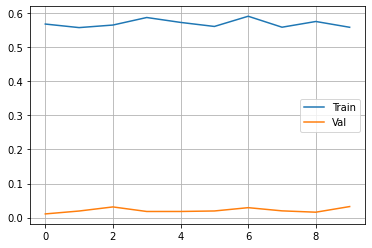

In [86]:
plt.plot(trainscores,label = "Train")
plt.plot(testscores, label = 'Val')
plt.legend()
plt.grid(True)
plt.show()

This plot shows the trainscores and testscores on each iteration

In [87]:
# Choosing the best model based on highest test score.
test_score, train_score, threshold, est = BEST(trainscores, testscores, TR, Models)
print(test_score, train_score)

0.03241293705530479 0.5579981440528232


In [88]:
# Using the best model
LR = est
LR

LogisticRegression(C=100000.0, l1_ratio=0.9437813902681133, n_jobs=-1,
                   penalty='l1', solver='saga')

In [89]:
# Fitting the calibrated classifier over the best model
sig_clf = CalibratedClassifierCV(LR, method="isotonic")
sig_clf.fit(X_train_standard, y_train_sam)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=100000.0,
                                                         l1_ratio=0.9437813902681133,
                                                         n_jobs=-1,
                                                         penalty='l1',
                                                         solver='saga'),
                       method='isotonic')

In [90]:
Y_predicted_val = sig_clf.predict_proba(X_val_standard)[:, 1]

Y_predicted_train = sig_clf.predict_proba(X_train_standard)[:, 1]

# Threshold Tuning based on the original Val Dataset.
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_sam, Y_predicted_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, Y_predicted_val)
thresholds = np.linspace(0.0, 1.0, num=len(val_thresholds))
best_t = find_best_threshold(val_thresholds, val_fpr, val_tpr)

the maximum value of sqrt(tpr*(1-fpr)) 0.6243670603911279 for threshold 0.703


The Prescision Score:  0.9685938615274804
The Recall Score:  0.9841138100667599
The ROC Score:  0.9949805752208939
The F1 Score:  0.9762921602052826
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    310253
           1       0.97      0.98      0.98    248203

    accuracy                           0.98    558456
   macro avg       0.98      0.98      0.98    558456
weighted avg       0.98      0.98      0.98    558456

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


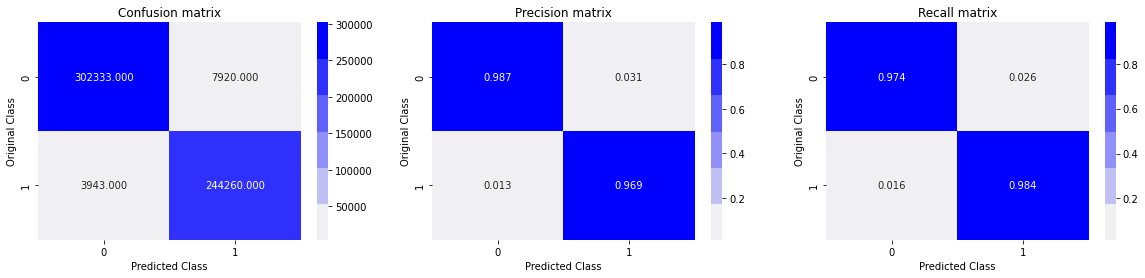

The Prescision Score:  0.0007127583749109052
The Recall Score:  0.4
The ROC Score:  0.6779383048382696
The F1 Score:  0.001422981145499822
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    330993
           1       0.00      0.40      0.00        15

    accuracy                           0.97    331008
   macro avg       0.50      0.69      0.49    331008
weighted avg       1.00      0.97      0.99    331008

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


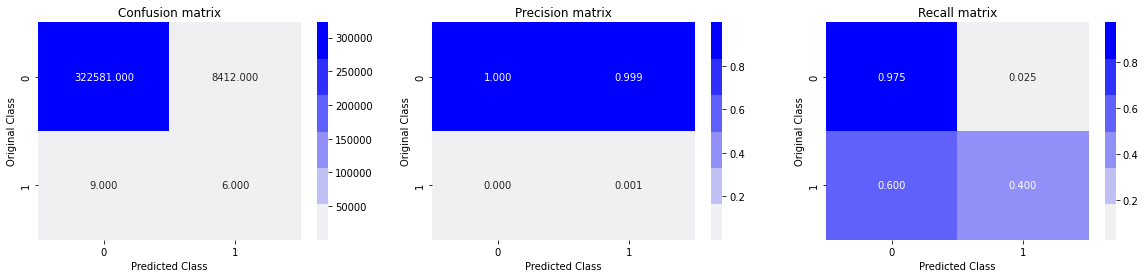

In [91]:
# Getting the metrics based on the optimal threshold value
Metrics(sig_clf, X_train_standard, y_train_sam, best_t) # Train dataset
print('='*100)
print('='*100)
Metrics(sig_clf, X_val_standard, y_val, best_t) # Val dataset

The Prescision Score:  0.00023199164830066117
The Recall Score:  0.2857142857142857
The ROC Score:  0.6197642529151428
The F1 Score:  0.0004636068613815484
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    330148
           1       0.00      0.29      0.00         7

    accuracy                           0.97    330155
   macro avg       0.50      0.63      0.49    330155
weighted avg       1.00      0.97      0.99    330155

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


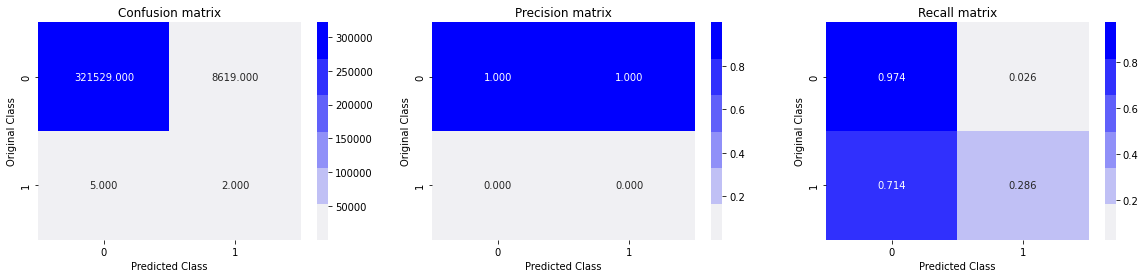

In [92]:
Metrics(sig_clf, X_test_standard, y_test, best_t) # Test dataset

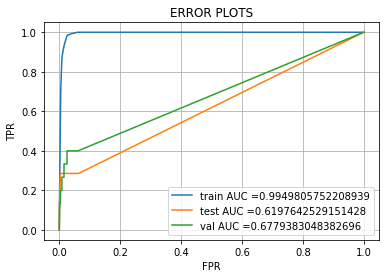

In [93]:
# Plotting ROC curve for Train, Val and Test.
Y_predicted_test = sig_clf.predict_proba(X_test_standard)[:, 1]

test_fpr, test_tpr, te_thresholds = roc_curve(y_test, Y_predicted_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(val_fpr, val_tpr, label="val AUC ="+str(auc(val_fpr, val_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

This plot shows the roc_curve of train, val and test dataset.

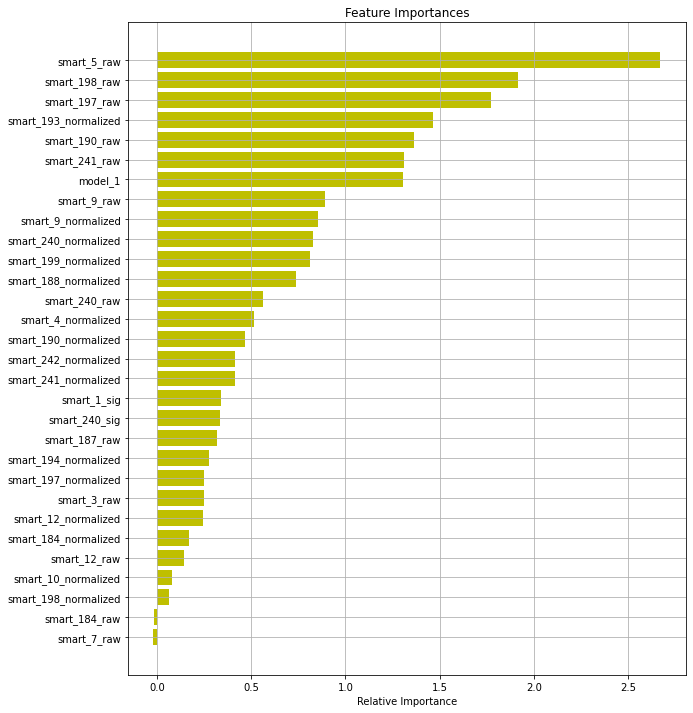

In [94]:
# FeatureImportances by LR.
LR.fit(X_train_standard, y_train_sam)
features = list(Data.columns)[5:]
features.append('model_1')
features.append('model_0')
importances = LR.coef_[0]
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='y', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid(True)
plt.show()

|  Data| Precision  | Recall | ROC-Score | F1-Score |
|------------|--------|----------------------|----------||
|      Train |  0.8080|           0.9911 |  0.9929 | 0.8903|
|    Val   |  0.00012    |  1.0        |   0.9392 |0.00024|
|    Test  |    0.00012  |    0.8333 |   0.8468 |0.00024|